# **micrograd intermediate**

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Value Class for Implementing the Backprop

In [49]:
class Value:

    def __init__(self,data,_children = (), _op = '',label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    #Adding Operations allowed by micrograd
    
    def __add__(self,otherVar):
        otherVar = otherVar if isinstance(otherVar,Value) else Value(otherVar)
        output = Value(self.data + otherVar.data, (self,otherVar),'+')
        
        def _backward():
            self.grad += 1.0 * output.grad
            otherVar.grad += 1.0 * output.grad
        output._backward = _backward

        return output

    def __radd__(self,otherVar): #otherVar + self
        return self + otherVar
    
    def __neg__(self):
        return self * -1

    def __sub__(self,otherVar):
        return self + (-otherVar)
    
    def __mul__(self,otherVar):
        otherVar = otherVar if isinstance(otherVar,Value) else Value(otherVar)
        output = Value(self.data * otherVar.data,(self,otherVar),'*')

        def _backward():
            self.grad += otherVar.data * output.grad
            otherVar.grad += self.data * output.grad  
        output._backward = _backward

        return output

    def __rmul__(self,otherVar):  #OtherVar * self
        return self * otherVar

    def __truediv__(self,otherVar): # self/otherVar
        return self * (otherVar ** -1)
        
    def tanh(self):
        x = self.data
        t = ((math.exp(2*x)-1)/(math.exp(2*x)+1))
        output = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1 - (t**2)) * output.grad
        output._backward = _backward

        return output

    def exp(self):
        x = self.data
        output = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += output.data * output.grad # output.data is just math.exp(x)
        output._backward = _backward

        return output

    def __pow__(self,otherVar):
        assert isinstance(otherVar,(int,float)) # Ensuring only int or float powers are given
        output = Value(self.data**otherVar,(self,),f"**{otherVar}")

        def _backward():
            self.grad += otherVar * (self.data ** (otherVar - 1)) * output.grad
        output._backward = _backward

        return output

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

## Graph Visualization to demonstrate Backprop

In [283]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

#### Adding Code to allow constant interger addition
- Example : a + 1, a * 1
- Check if Value object, if not wrap it in Value object 

In [51]:
a = Value(2.0)
a + 1

Value(data = 3.0)

In [52]:
a * 2

Value(data = 4.0)

#### Adding Reverse add and mul Code
- Example 1 * a
- Adding rmul()

In [53]:
2 * a

Value(data = 4.0)

In [54]:
2 + a

Value(data = 4.0)

In [55]:
a.exp()

Value(data = 7.38905609893065)

#### Implementing Division
- Division is just a special case of power
- How ?
- a/b = a * (1/b)
- a * 1/b = a * (b^-1)

In [56]:
a = Value(2.0,label = 'a')
b = Value(4.0,label = 'b')
a/b

Value(data = 0.5)

In [57]:
a-b

Value(data = -2.0)

## Example of Perceptron form micrograd_basics

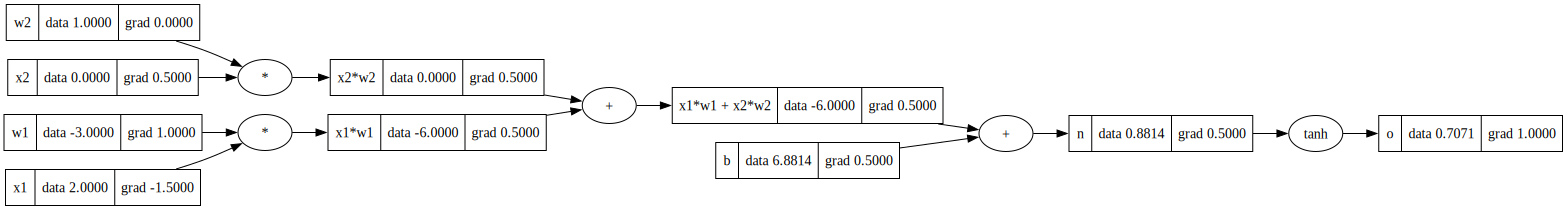

In [58]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#Bias of the Perceptron/Neuron
b = Value(6.8813735870195432, label = 'b')  #Compilcated Bias value to get nice clean numbers while backprop

#Neuron Calculation
# x1 * w1 + x2 * w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

#### Redifining tanh as atomic components

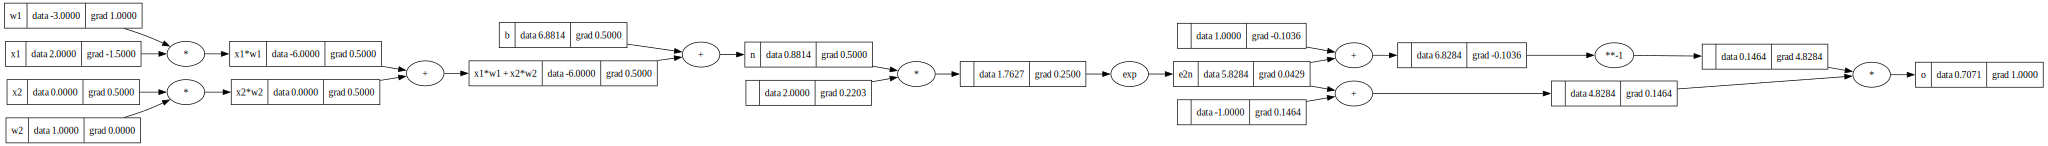

In [59]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#Bias of the Perceptron/Neuron
b = Value(6.8813735870195432, label = 'b')  #Compilcated Bias value to get nice clean numbers while backprop

#Neuron Calculation
# x1 * w1 + x2 * w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#------
e2n = (2*n).exp(); e2n.label = 'e2n'
o = (e2n - 1)/(e2n + 1)
#------
o.label = 'o'
o.backward()
draw_dot(o)

## Doing the same implementation but by using **PyTorch**

In [60]:
import torch

In [61]:
#Initializing the scalar values as tensors
x1 = torch.tensor([2.0]).double();                    x1.requires_grad = True
x2 = torch.tensor([0.0]).double();                    x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();                   w1.requires_grad = True
w2 = torch.tensor([1.0]).double();                    w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double();      b.requires_grad = True

#Implementing the connections/formulas
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

#Check Values
print(o.data.item())
o.backward()

print("---")
print("x2 : ",x2.grad.item())
print("w2 : ",w2.grad.item())
print("x1 : ",x1.grad.item())
print("w1 : ",w1.grad.item())


0.7071066904050358
---
x2 :  0.5000001283844369
w2 :  0.0
x1 :  -1.5000003851533106
w1 :  1.0000002567688737


## Building a Neural Network / MLP(Multi Layer Perceptron)

In [133]:
import random

#### Key Terminologies
- **x is the array of previous nodes/neurons which contain their scalar values**
- w is the weight of the connection, connecting to another node/neuron
- b is the bias that is added like a trigger happy function

#### Concept
- w and b are set to random values
- via backprop these weight and bias values are learned,
- which is stored by every neuron,
- for all the previous neurons connected to it

### Building a Neuron
- The neuron gets the value Array from the previous neurons
- For this, we are considering 'nin' number of neurons before
- So the neuron contains the weights tied with each previous neuron, wi
- And also a bias with which it can then multiply later

In [158]:
class Neuron:

    def __init__(self,nin): #nin -> (n)umber of (in)puts
        #Creating nin Value objects as weights with random value between  -1 and 1
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]

        #Creating a bias for the neuron
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # ∑w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        output = act.tanh()
        return output

    def parameters(self):
        return self.w + [self.b]

In [159]:
x = [2.0,3.0]
n = Neuron(2) #number of inputs is 2
n(x)

Value(data = -0.23513303436313532)

### Building a Layer of Neurons

In [160]:
class Layer:

    def __init__(self,nin,nout): #nout -> (n)umber of (out)puts
        #Creating nout number of neurons per layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        #Initializing the neurons as done earlier
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs)==1 else outputs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

In [161]:
x = [2.0,3.0]
n = Layer(2,3) #number of inputs is 2
n(x)

[Value(data = 0.586295568726083),
 Value(data = -0.9869386996925547),
 Value(data = -0.9933848428424537)]

### Building a MLP(Multi Layer Perceptron)

In [162]:
class MLP:

    def __init__(self,nin,nouts): #nouts -> number of outputs per layer(is an array)
        #Adding input layer size also
        sz = [nin]+nouts
        
        #Creates layer by layer, taking sizes one by one
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        #Calling these layers sequentially
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [163]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data = 0.49195939608481454)

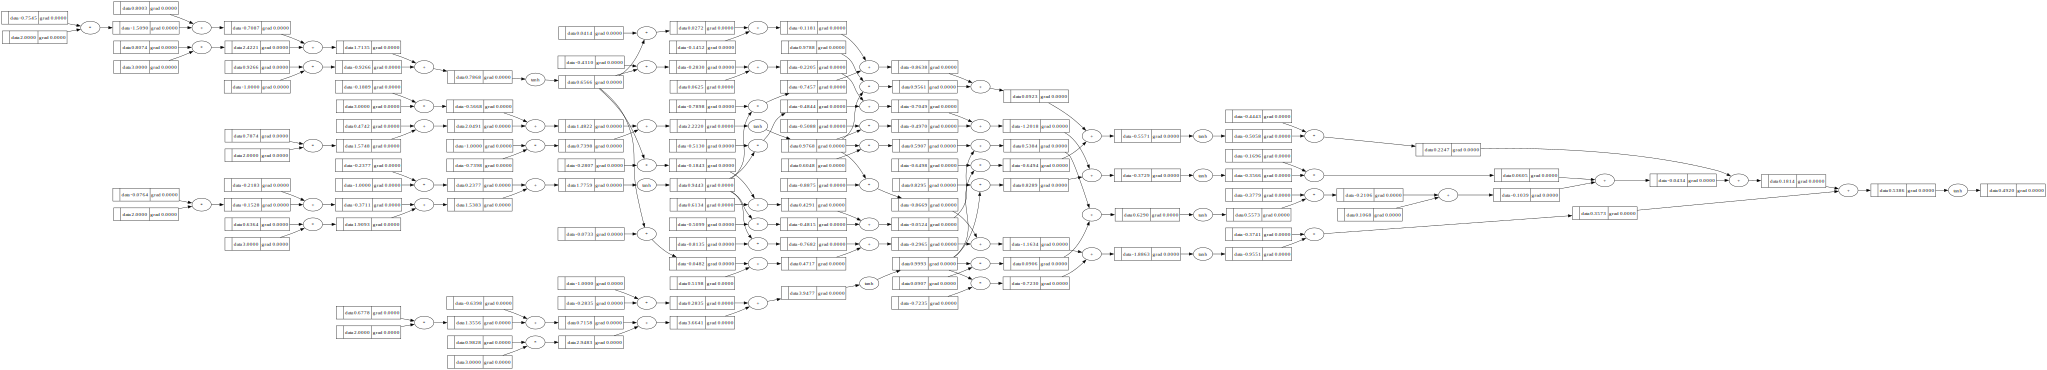

In [164]:
draw_dot(n(x))

### Binary Classifier using micrograd

In [165]:
n = MLP(3,[4,4,1])
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,-1.0,-1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #Desired Targets

In [182]:
#Checking current predicition
ypred = [n(x) for x in xs]
ypred

[Value(data = -0.8395138068635172),
 Value(data = -0.8764899926332254),
 Value(data = -0.8116184459843668),
 Value(data = -0.8566140383203803)]

### Training the neural net using Loss Function (MSE - Mean Squared Error)
- ygd = y ground truth
- yout = y output

In [183]:
loss = sum((yout-ygd)**2 for ygd, yout in zip(ys,ypred))
loss

Value(data = 6.881569064742905)

In [184]:
loss.backward()

In [185]:
n.layers[0].neurons[0].w[0].grad

0.2015912054760753

In [186]:
n.layers[0].neurons[0].w[0].data

-0.38377924151485243

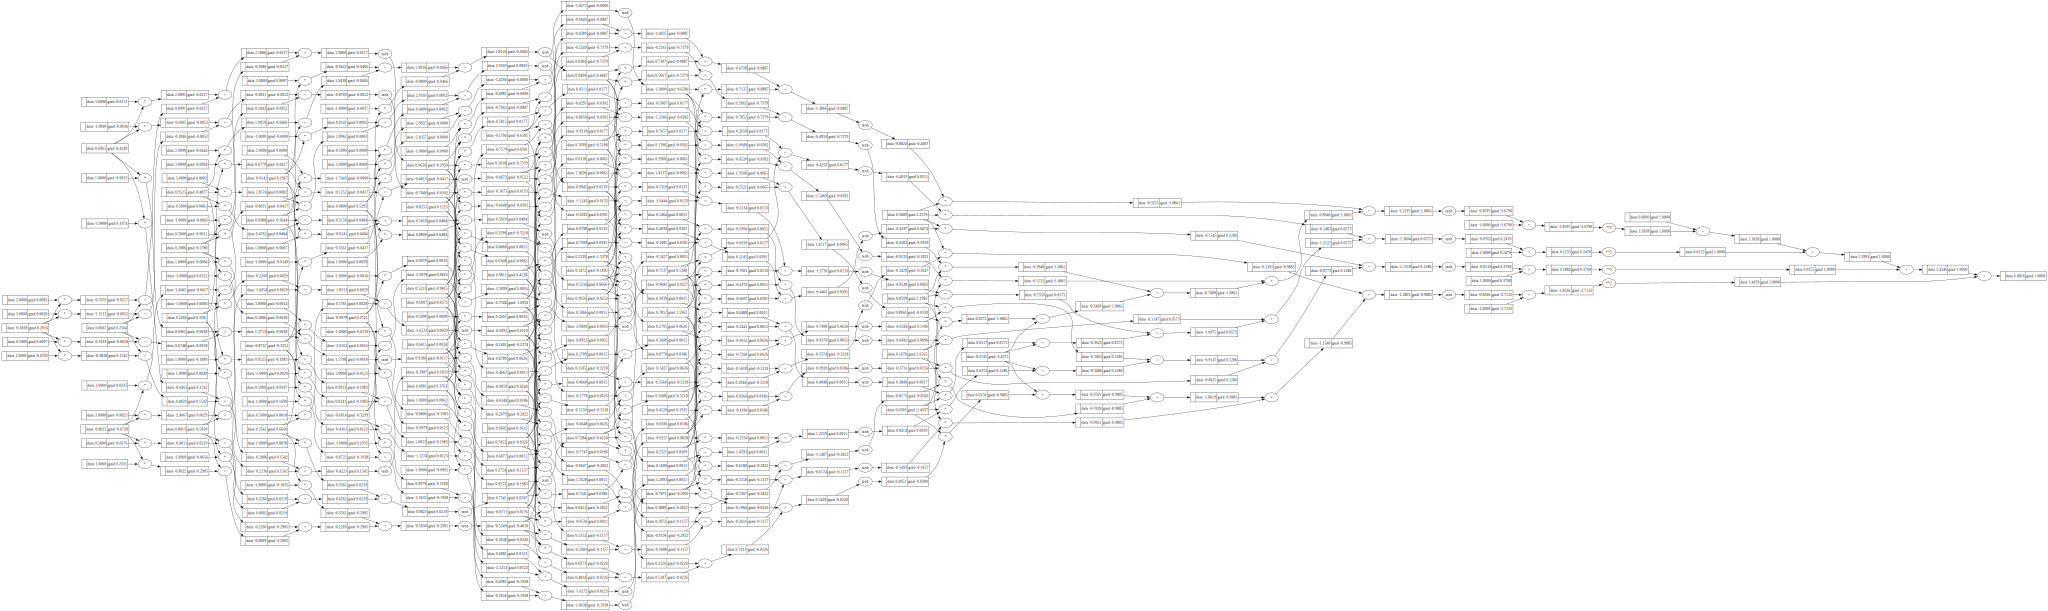

In [187]:
draw_dot(loss)

In [188]:
n.parameters()

[Value(data = -0.38377924151485243),
 Value(data = 0.6964858372166298),
 Value(data = 0.2085593000089443),
 Value(data = 0.866690179852287),
 Value(data = -0.8022326158324147),
 Value(data = 0.22598015554321588),
 Value(data = 0.35613971983711745),
 Value(data = 0.8013299060970491),
 Value(data = 0.9524762149667747),
 Value(data = -0.014052005065599713),
 Value(data = 0.0800432153041711),
 Value(data = 0.038808234094136154),
 Value(data = -0.8721592456264928),
 Value(data = -0.9978978396573062),
 Value(data = 0.4981348921309535),
 Value(data = -0.6913615001213373),
 Value(data = 0.6615477207412985),
 Value(data = -0.07105252028147288),
 Value(data = 0.3055931763652726),
 Value(data = 0.25210296933474974),
 Value(data = 0.7451644384472376),
 Value(data = 0.5213477693201822),
 Value(data = -0.08588676177708265),
 Value(data = 0.5339191587916239),
 Value(data = 0.7851785438024899),
 Value(data = -0.7567850998699397),
 Value(data = -0.6906614615475215),
 Value(data = 0.9601900536078081),
 

In [189]:
len(n.parameters())

41

In [190]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [191]:
n.layers[0].neurons[0].w[0].grad

0.2015912054760753

In [192]:
n.layers[0].neurons[0].w[0].data

-0.3857951535696132

In [195]:
#Checking current predicition
ypred = [n(x) for x in xs]

#Checking updated loss value
loss = sum((yout-ygd)**2 for ygd, yout in zip(ys,ypred))
print(loss)
print(ypred)

Value(data = 6.589893133611113)
[Value(data = -0.7874731877079149), Value(data = -0.8480986932801934), Value(data = -0.7698585185147967), Value(data = -0.8217556445234442)]


### Steps :
1. Do a Forward Pass to decrease the loss
2. Do a Backward Pass -> this caculates the gradients
3. Update the values using the data
4. Then check if the loss is 0 or comparable to stop, as you have reached the required target values

In [280]:
loss.backward()

In [281]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [282]:
#Checking current predicition
ypred = [n(x) for x in xs]

#Checking updated loss value
loss = sum((yout-ygd)**2 for ygd, yout in zip(ys,ypred))
print(loss)
print(ypred)

Value(data = 0.008177336791254678)
[Value(data = 0.9169572966524248), Value(data = -0.9642279860376691), Value(data = -0.9990023132791749), Value(data = 0.999216514028723)]


### Just iteratively repeating the steps we get
- Loss at 0.008 -> negligible
- ypred values -> 0.91,-0.96,-0.99,0.99
- target values -> 1.0,-1.0,-1.0,1.0
- We have reached the target values as needed
--- 
- Values for my training run,
- Different for different runs
- Due to different weights and biases, due to random
- Also different loss calculations as well